In [1]:
import random
import pandas as pd
import numpy as np
import os
import re
import glob
import cv2
import timm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

# 이미지 증량 및 처리를 위한 라이브러리 ( albumentations )
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from albumentations.core.transforms_interface import ImageOnlyTransform
import torchvision.models as models


# sklearn 
from sklearn.model_selection import train_test_split # train test Split 
from sklearn import preprocessing
from sklearn.metrics import f1_score # f1 score 
from sklearn.metrics import classification_report
from tqdm.auto import tqdm 

import warnings
warnings.filterwarnings(action='ignore') 

/mnt/sdb/anaconda_env/dacon/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data Load

In [2]:
all_img_list = glob.glob('../data/train/*/*')
df = pd.DataFrame(columns=['img_path', 'rock_type'])
df['img_path'] = all_img_list
df['rock_type'] = df['img_path'].apply(lambda x : str(x).split('/')[3])

In [3]:
# 총 7개 종류로 분류를 진행 
df["rock_type"].unique(), len(df["rock_type"].unique())


(array(['Andesite', 'Etc', 'Granite', 'Weathered_Rock', 'Basalt',
        'Mud_Sandstone', 'Gneiss'], dtype=object),
 7)

In [4]:
df["rock_type"].value_counts()

# 상당한 불 균형을 이루고 있음.
# 이미지를 살펴봤을 때, 색상변경, rotate , flip이 되어있는 경우가 존재함.
# 사전 증량되어있는 데이터를 지우고 난 후 비율 살펴보기


rock_type
Granite           92923
Mud_Sandstone     89467
Gneiss            73914
Andesite          43802
Weathered_Rock    37169
Basalt            26810
Etc               15935
Name: count, dtype: int64

In [5]:
import seaborn as sns

<Axes: xlabel='rock_type', ylabel='count'>

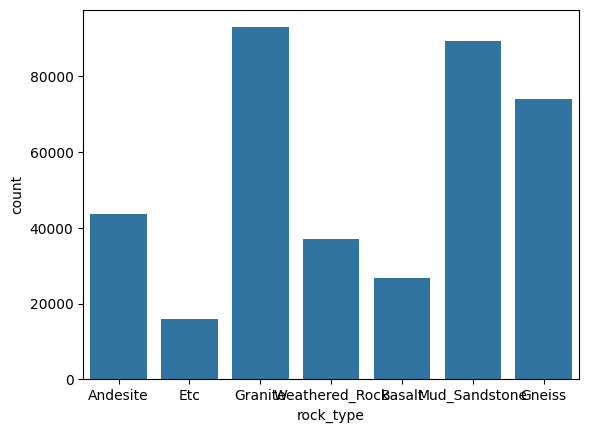

In [6]:
sns.countplot(df , x = "rock_type")

In [11]:
rock_list = df["rock_type"].unique().tolist()

In [13]:
df[df["rock_type"] == "Basalt"]['img_path'].to_list()

['../data/train/Basalt/TRAIN_06260.jpg',
 '../data/train/Basalt/TRAIN_06343.jpg',
 '../data/train/Basalt/TRAIN_23771.jpg',
 '../data/train/Basalt/TRAIN_00636.jpg',
 '../data/train/Basalt/TRAIN_24341.jpg',
 '../data/train/Basalt/TRAIN_04535.jpg',
 '../data/train/Basalt/TRAIN_22111.jpg',
 '../data/train/Basalt/TRAIN_24735.jpg',
 '../data/train/Basalt/TRAIN_12767.jpg',
 '../data/train/Basalt/TRAIN_14736.jpg',
 '../data/train/Basalt/TRAIN_18458.jpg',
 '../data/train/Basalt/TRAIN_16326.jpg',
 '../data/train/Basalt/TRAIN_11784.jpg',
 '../data/train/Basalt/TRAIN_15223.jpg',
 '../data/train/Basalt/TRAIN_02467.jpg',
 '../data/train/Basalt/TRAIN_16488.jpg',
 '../data/train/Basalt/TRAIN_13583.jpg',
 '../data/train/Basalt/TRAIN_15543.jpg',
 '../data/train/Basalt/TRAIN_13698.jpg',
 '../data/train/Basalt/TRAIN_26757.jpg',
 '../data/train/Basalt/TRAIN_13920.jpg',
 '../data/train/Basalt/TRAIN_18140.jpg',
 '../data/train/Basalt/TRAIN_24762.jpg',
 '../data/train/Basalt/TRAIN_04845.jpg',
 '../data/train/

# 각 돌 종류별 비슷한 이미지 추출 하여 제거 

In [ ]:
import torch
import clip
from PIL import Image
import numpy as np
import os
from tqdm import tqdm

# 장치 설정
device = "cuda" if torch.cuda.is_available() else "cpu"

# CLIP 모델 로드
model, preprocess = clip.load("ViT-L/14", device=device)

rock_list = df["rock_type"].unique().tolist()

# 임베딩 계산 함수
def get_clip_embeddings(image_paths, batch_size=16, grayscale=False):
    all_embeddings = []

    for i in tqdm(range(0, len(image_paths), batch_size)):
        batch_paths = image_paths[i:i + batch_size]
        batch_images = []

        for path in batch_paths:
            img = Image.open(path).convert("L" if grayscale else "RGB")
            img = img.convert("RGB")  # 흑백도 RGB 3채널로 확장
            img_tensor = preprocess(img)
            batch_images.append(img_tensor)

        # 배치 텐서 만들기: (B, 3, 224, 224)
        batch_tensor = torch.stack(batch_images).to(device)

        with torch.no_grad():
            batch_embeddings = model.encode_image(batch_tensor)

        all_embeddings.append(batch_embeddings.cpu())

    return torch.cat(all_embeddings, dim=0)  # (100, D)
for rock_name in rock_list : 
    # 이미지 경로 리스트 (예: df['img_path'])
    image_paths = df[df["rock_type"] == rock_name]['img_path'].tolist()  # 100개 이미지

    # 임베딩 계산
    embeddings = get_clip_embeddings(image_paths, batch_size=1024, grayscale=True)

    # 임베딩 저장
    np.save(f'image_embeddings_{rock_name}.npy', embeddings.numpy())  # .npy 파일로 저장
    print(f"{rock_name} 임베딩 저장 완료.")

100%|██████████| 43/43 [11:17<00:00, 15.75s/it]


Andesite 임베딩 저장 완료.


100%|██████████| 16/16 [02:51<00:00, 10.75s/it]


Etc 임베딩 저장 완료.


100%|██████████| 91/91 [26:44<00:00, 17.63s/it]


Granite 임베딩 저장 완료.


100%|██████████| 37/37 [12:13<00:00, 19.83s/it]


Weathered_Rock 임베딩 저장 완료.


100%|██████████| 27/27 [04:56<00:00, 10.98s/it]


Basalt 임베딩 저장 완료.


 61%|██████▏   | 54/88 [17:36<10:30, 18.54s/it]

In [ ]:
import os
import shutil
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

for rock_name in rock_list : 
# 저장된 임베딩 불러오기
    embeddings = np.load(f'image_embeddings_{rock_name}.npy')

    # 거리 계산 (코사인 유사도 예시)
    similarity_matrix = cosine_similarity(embeddings)

    # 유사도가 0.97 미만인 이미지들을 복사할 폴더 설정
    threshold = 0.97
    target_folder = f'/mnt/sdb/sim/dacon/data/similar/{rock_name}'  # 복사할 폴더 경로
    os.makedirs(target_folder, exist_ok=True)  # 폴더가 없으면 생성
    image_paths = df[df["rock_type"] == rock_name]['img_path'].tolist()  # 100개 이미지

# 이미지 경로 리스트 (여기서는 예시로 설정)
# image_paths = ['image_path_1.jpg', 'image_path_2.jpg', 'image_path_3.jpg', ...]  # 실제 경로로 채우세요

    # 복사할 이미지 인덱스 저장 리스트
    to_copy = set()

    # 유사도 행렬에서 0.97 미만인 값 찾기
    for i in range(similarity_matrix.shape[0]):
        for j in range(i + 1, similarity_matrix.shape[1]):  # 대칭 행렬이므로 한쪽만 확인
            if similarity_matrix[i, j] < threshold:
                print(f"이미지 {i}와 이미지 {j}는 유사도가 {similarity_matrix[i, j]:.3f}로 다르므로 복사 대상입니다.")
                # 유사도가 0.97 미만인 경우 첫 번째 이미지를 복사 목록에 추가
                to_copy.add(i)  # 첫 번째 이미지를 복사한다고 가정

    # 복사할 이미지 경로 출력
    print(f"복사할 이미지 인덱스: {to_copy}")

    # 복사된 이미지를 실제로 복사하기
    for idx in sorted(to_copy, reverse=True):  # 인덱스를 뒤에서부터 복사해야 순서가 뒤틀리지 않음
        image_to_copy = image_paths[idx]
        if os.path.exists(image_to_copy):
            target_path = os.path.join(target_folder, os.path.basename(image_to_copy))  # 타겟 폴더 경로
            shutil.copy(image_to_copy, target_path)  # 이미지 복사
            print(f"이미지 {image_to_copy} 복사 완료.")
        else:
            print(f"이미지 {image_to_copy}를 찾을 수 없습니다.")


코사인 유사도 행렬:
[[1.         0.91554485 0.91358031 ... 0.92911867 0.89523824 0.8905017 ]
 [0.91554485 1.         0.89438243 ... 0.90902764 0.89421408 0.9236207 ]
 [0.91358031 0.89438243 1.         ... 0.9396055  0.94083468 0.91679877]
 ...
 [0.92911867 0.90902764 0.9396055  ... 1.         0.92075219 0.93641065]
 [0.89523824 0.89421408 0.94083468 ... 0.92075219 1.         0.90719758]
 [0.8905017  0.9236207  0.91679877 ... 0.93641065 0.90719758 1.        ]]
이미지 0와 이미지 1는 유사도가 0.916로 다르므로 복사 대상입니다.
이미지 0와 이미지 2는 유사도가 0.914로 다르므로 복사 대상입니다.
이미지 0와 이미지 3는 유사도가 0.832로 다르므로 복사 대상입니다.
이미지 0와 이미지 4는 유사도가 0.924로 다르므로 복사 대상입니다.
이미지 0와 이미지 5는 유사도가 0.861로 다르므로 복사 대상입니다.
이미지 0와 이미지 6는 유사도가 0.800로 다르므로 복사 대상입니다.
이미지 0와 이미지 7는 유사도가 0.870로 다르므로 복사 대상입니다.
이미지 0와 이미지 8는 유사도가 0.909로 다르므로 복사 대상입니다.
이미지 0와 이미지 9는 유사도가 0.841로 다르므로 복사 대상입니다.
이미지 0와 이미지 10는 유사도가 0.895로 다르므로 복사 대상입니다.
이미지 0와 이미지 11는 유사도가 0.907로 다르므로 복사 대상입니다.
이미지 0와 이미지 12는 유사도가 0.850로 다르므로 복사 대상입니다.
이미지 0와 이미지 13는 유사도가 0.913로 다르므로 복사 대상입니다.
이미지 0와 

In [12]:
similarity_matrix[0].shape

(10000,)

In [151]:
import torch
import clip
from PIL import Image
from sklearn.metrics.pairwise import cosine_similarity
import os

device = "cuda" if torch.cuda.is_available() else "cpu"
# model, preprocess = clip.load("ViT-B/32", device=device)
model, preprocess = clip.load("ViT-L/14", device=device)

def get_embedding(image_path):
    # 1. 원본 이미지 로드 후 그레이스케일로 변환
    image = Image.open(image_path).convert("L")  # 'L' = grayscale (1채널)
    
    # 2. 다시 3채널로 확장 (CLIP은 3채널 입력 필요)
    image = image.convert("RGB")

    # 3. CLIP 전처리 및 임베딩
    image_tensor = preprocess(image).unsqueeze(0).to(device)
    with torch.no_grad():
        embedding = model.encode_image(image_tensor)
    return embedding.cpu().numpy(), image_tensor.cpu().numpy()

img1_emb , img1 = get_embedding(df['img_path'][133688])
img2_emb , img2 = get_embedding(df['img_path'][76348])

similarity = cosine_similarity(img1_emb, img2_emb)
print("유사도:", similarity[0][0])

유사도: 0.9949000818130469


In [152]:
tt

,img_path,rock_type
141907,../data/train/Granite/TRAIN_00000.jpg,Granite
146343,../data/train/Granite/TRAIN_00001.jpg,Granite
133688,../data/train/Granite/TRAIN_00002.jpg,Granite
121883,../data/train/Granite/TRAIN_00003.jpg,Granite
132407,../data/train/Granite/TRAIN_00004.jpg,Granite
91588,../data/train/Granite/TRAIN_00005.jpg,Granite
76348,../data/train/Granite/TRAIN_00006.jpg,Granite
119772,../data/train/Granite/TRAIN_00007.jpg,Granite
87592,../data/train/Granite/TRAIN_00008.jpg,Granite
66058,../data/train/Granite/TRAIN_00009.jpg,Granite


In [150]:
tt

,img_path,rock_type
141907,../data/train/Granite/TRAIN_00000.jpg,Granite
146343,../data/train/Granite/TRAIN_00001.jpg,Granite
133688,../data/train/Granite/TRAIN_00002.jpg,Granite
121883,../data/train/Granite/TRAIN_00003.jpg,Granite
132407,../data/train/Granite/TRAIN_00004.jpg,Granite
91588,../data/train/Granite/TRAIN_00005.jpg,Granite
76348,../data/train/Granite/TRAIN_00006.jpg,Granite
119772,../data/train/Granite/TRAIN_00007.jpg,Granite
87592,../data/train/Granite/TRAIN_00008.jpg,Granite
66058,../data/train/Granite/TRAIN_00009.jpg,Granite


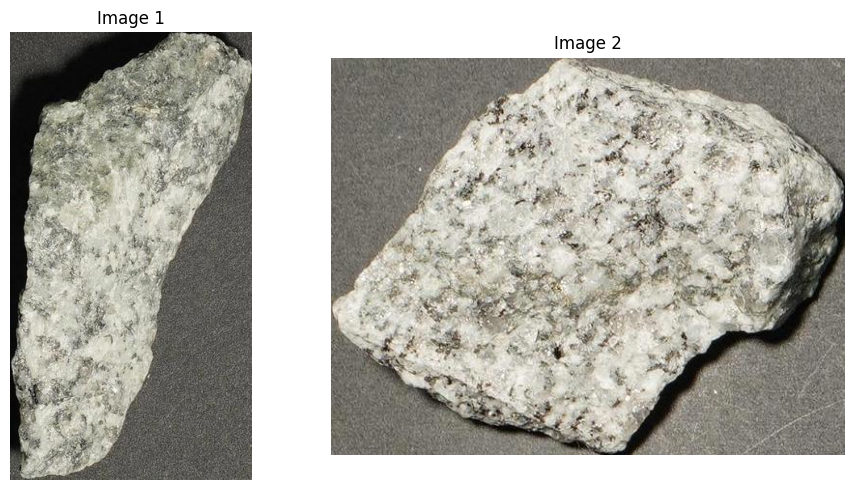

In [161]:
import cv2
from matplotlib import pyplot as plt

def show_two_images(path1, path2, titles=["Image 1", "Image 2"]):
    img1 = cv2.imread(path1)
    img2 = cv2.imread(path2)

    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
    img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(img1)
    plt.title(titles[0])
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(img2)
    plt.title(titles[1])
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# 사용 예시
show_two_images(tt['img_path'][76348], tt['img_path'][121883])
# show_two_images(df['img_path'][146343], df['img_path'][132407])


In [157]:
tt

,img_path,rock_type
141907,../data/train/Granite/TRAIN_00000.jpg,Granite
146343,../data/train/Granite/TRAIN_00001.jpg,Granite
133688,../data/train/Granite/TRAIN_00002.jpg,Granite
121883,../data/train/Granite/TRAIN_00003.jpg,Granite
132407,../data/train/Granite/TRAIN_00004.jpg,Granite
91588,../data/train/Granite/TRAIN_00005.jpg,Granite
76348,../data/train/Granite/TRAIN_00006.jpg,Granite
119772,../data/train/Granite/TRAIN_00007.jpg,Granite
87592,../data/train/Granite/TRAIN_00008.jpg,Granite
66058,../data/train/Granite/TRAIN_00009.jpg,Granite
